In [2]:
# Install required packages (if not already installed)
#!pip install imbalanced-learn xgboost scikit-learn seaborn matplotlib --quiet

In [4]:
#!pip install -U imbalanced-learn

  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.2
    Uninstalling imbalanced-learn-0.12.2:
      Successfully uninstalled imbalanced-learn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hicexplorer 3.7.3 requires hic2cool>=0.8.3, but you have hic2cool 0.5.1 which is incompatible.
hicexplorer 3.7.3 requires intervaltree>=3.1, but you have intervaltree 2.1.0 which is incompatible.
hicexplorer 3.7.3 requires ipykernel>=6.25.2, but you have ipykernel 6.17.1 which is incompatible.
hicexplorer 3.7.3 requires pandas>=2.0, but you have pandas 1.5.1 which is incompatible.
hicexplorer 3.7.3 requires pygenometracks>=3.8, but you have pygenometracks 3.0 which is incompatible.


In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, auc,
                             confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, matthews_corrcoef)
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer

In [3]:
# Load datasets (ensure these CSVs are uploaded to Colab environment)
train = pd.read_csv("../Train_RCDI_categorized.csv", index_col = 0)
test = pd.read_csv("../Test_RCDI_categorized.csv", index_col = 0)
val1 = pd.read_csv("../GSE39582_RCDI_categorized.csv", index_col = 0)
val2 = pd.read_csv("../GSE161158_RCDI_categorized.csv", index_col = 0)
train.drop(columns = ["OS_MONTHS","OS_STATUS","RCDI"], inplace =True)
test.drop(columns = ["OS_MONTHS","OS_STATUS","RCDI"], inplace=True)
val1.drop(columns = ["OS_MONTHS","OS_STATUS","RCDI"], inplace=True)
val2.drop(columns = ["OS_MONTHS","OS_STATUS","RCDI"], inplace=True)

train.columns, test.columns, val1.columns, val2.columns

(Index(['ACTA2', 'ALOXE3', 'ATP2B4', 'AURKA', 'BID', 'C1QA', 'C1QC', 'CDK4',
        'CDK6', 'CDKN2A', 'CDO1', 'CGAS', 'CHMP6', 'CLN3', 'CR1', 'CXCL2',
        'EGFR', 'ETS2', 'GDF15', 'GPX2', 'GSDMC', 'GZMB', 'IGHG1', 'IL18',
        'KNG1', 'LAMA2', 'LAMC2', 'MAP1B', 'MYC', 'NFATC1', 'NOX4', 'PLIN4',
        'RGS4', 'S100A11', 'SLC2A3', 'SNAI1', 'STAT1', 'SUN2', 'TCF7', 'TP63',
        'TRAF3IP2', 'TXNIP', 'YAP1', 'RiskClass'],
       dtype='object'),
 Index(['ACTA2', 'ALOXE3', 'ATP2B4', 'AURKA', 'BID', 'C1QA', 'C1QC', 'CDK4',
        'CDK6', 'CDKN2A', 'CDO1', 'CGAS', 'CHMP6', 'CLN3', 'CR1', 'CXCL2',
        'EGFR', 'ETS2', 'GDF15', 'GPX2', 'GSDMC', 'GZMB', 'IGHG1', 'IL18',
        'KNG1', 'LAMA2', 'LAMC2', 'MAP1B', 'MYC', 'NFATC1', 'NOX4', 'PLIN4',
        'RGS4', 'S100A11', 'SLC2A3', 'SNAI1', 'STAT1', 'SUN2', 'TCF7', 'TP63',
        'TRAF3IP2', 'TXNIP', 'YAP1', 'RiskClass'],
       dtype='object'),
 Index(['ACTA2', 'ALOXE3', 'ATP2B4', 'AURKA', 'BID', 'C1QA', 'C1QC', 'CDK4',
       

In [4]:
# Features and Labels
X_train = train.drop(columns=["RiskClass"])
y_train = train["RiskClass"].map({"low": 0, "high": 1})

X_test = test.drop(columns=["RiskClass"])
y_test = test["RiskClass"].map({"low": 0, "high": 1})

X_val1 = val1.drop(columns=["RiskClass"])
y_val1 = val1["RiskClass"].map({"low": 0, "high": 1})

X_val2 = val2.drop(columns=["RiskClass"])
y_val2 = val2["RiskClass"].map({"low": 0, "high": 1})

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val1.shape, y_val1.shape, X_val2.shape, y_val2.shape

((1300, 43), (1300,), (325, 43), (325,), (556, 43), (556,), (188, 43), (188,))

In [5]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val1 = scaler.transform(X_val1)
X_val2 = scaler.transform(X_val2)

In [6]:
# Define classifiers and hyperparameter grids
classifiers = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        "clf__C": np.logspace(-3, 3, 10),
        "clf__penalty": ["l2"]
    }),
    "SVM": (SVC(probability=True), {
        "clf__C": [0.1, 1, 10, 100],
        "clf__kernel": ["linear", "rbf"]
    }),
    "RandomForest": (RandomForestClassifier(), {
        "clf__n_estimators": [100, 200, 500],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    }),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [3, 5, 7],
        "clf__learning_rate": [0.01, 0.1, 0.2]
    }),
    "KNN": (KNeighborsClassifier(), {
        "clf__n_neighbors": [3, 5, 7, 9]
    }),
    "NaiveBayes": (GaussianNB(), {})
}

# Function to train and evaluate each classifier
results = {}
roc_data = {}
best_models = {}
val_results = {}
train_roc_data = {}
performance_table = []

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'mcc': make_scorer(matthews_corrcoef)
}

for name, (clf, params) in classifiers.items():
    print(f"\nTraining {name}...")
    pipe = ImbPipeline([
        ("smote", SMOTE()),
        ("clf", clf)
    ])
    
    search = RandomizedSearchCV(pipe, param_distributions=params, scoring="roc_auc", cv=5, n_iter=10, n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    best_models[name] = best_model


    cv_scores = cross_val_score(
        best_model, X_train, y_train,
        cv=cv10,
        scoring="roc_auc",
        n_jobs=-1
    )
    print(f"{name} - 10-Fold Cross-Validated Train AUC: Mean = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")
    
    # TRAIN
    y_train_pred = best_model.predict(X_train)
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_proba)
    train_roc_data[name] = train_auc

    # TEST
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_proba)
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_data[name] = (fpr, tpr)

    results[name] = {
        "Train AUC": train_auc,
        "Test AUC": test_auc
    }

    # VALIDATIONS
    val_metrics = {}
    for val_name, (X_val, y_val) in zip(["GSE39582", "GSE161158"], [(X_val1, y_val1), (X_val2, y_val2)]):
        y_val_pred = best_model.predict(X_val)
        y_val_proba = best_model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_proba)
        val_results[(name, val_name)] = val_auc
        val_metrics[val_name] = {
            "accuracy": accuracy_score(y_val, y_val_pred),
            "precision": precision_score(y_val, y_val_pred),
            "recall": recall_score(y_val, y_val_pred),
            "f1": f1_score(y_val, y_val_pred),
            "mcc": matthews_corrcoef(y_val, y_val_pred),
            "auc": val_auc
        }

     # 10-fold CV AUC with SMOTE in pipeline
    cv_scores = cross_val_score(
        best_model,
        X_train,
        y_train,
        cv=10,
        scoring="roc_auc",
        n_jobs=-1
    )
    
    # Collect summary row
    performance_table.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Train Precision": precision_score(y_train, y_train_pred),
        "Train Recall": recall_score(y_train, y_train_pred),
        "Train F1": f1_score(y_train, y_train_pred),
        "Train MCC": matthews_corrcoef(y_train, y_train_pred),

        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test Precision": precision_score(y_test, y_test_pred),
        "Test Recall": recall_score(y_test, y_test_pred),
        "Test F1": f1_score(y_test, y_test_pred),
        "Test MCC": matthews_corrcoef(y_test, y_test_pred),

        "GSE39582 Accuracy": val_metrics["GSE39582"]["accuracy"],
        "GSE39582 Precision": val_metrics["GSE39582"]["precision"],
        "GSE39582 Recall": val_metrics["GSE39582"]["recall"],
        "GSE39582 F1": val_metrics["GSE39582"]["f1"],
        "GSE39582 MCC": val_metrics["GSE39582"]["mcc"],

        "GSE161158 Accuracy": val_metrics["GSE161158"]["accuracy"],
        "GSE161158 Precision": val_metrics["GSE161158"]["precision"],
        "GSE161158 Recall": val_metrics["GSE161158"]["recall"],
        "GSE161158 F1": val_metrics["GSE161158"]["f1"],
        "GSE161158 MCC": val_metrics["GSE161158"]["mcc"],

        "CV10 Mean AUC": cv_scores.mean(),
        "CV10 Std AUC": cv_scores.std(),
        "Best Params": search.best_params_
    })

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.base import ClassifierMixin

results = {}
roc_data = {}
best_models = {}
val_results = {}
train_roc_data = {}
performance_table = []

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'mcc': make_scorer(matthews_corrcoef)
}

for name, (clf, params) in classifiers.items():
    print(f"\nTraining {name}...")

    pipe = ImbPipeline([
        ("smote", SMOTE()),
        ("clf", clf)
    ])
        
    search = RandomizedSearchCV(pipe, param_distributions=params, scoring="roc_auc", cv=5, n_iter=10, n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    best_models[name] = best_model

    # Cross-validated metrics on training data
    cv_results = cross_validate(
        best_model, X_train, y_train,
        scoring=scoring, cv=cv10, n_jobs=-1
    )


    # Store CV AUC
    train_roc_data[name] = cv_results['test_roc_auc'].mean()
    print(f"{name} - 10-Fold Cross-Validated AUC: Mean = {train_roc_data[name]:.4f}, Std = {cv_results['test_roc_auc'].std():.4f}")

    # TEST metrics
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_proba)
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_data[name] = (fpr, tpr)

    results[name] = {
        "Train AUC": train_roc_data[name],
        "Test AUC": test_auc
    }

    # VALIDATION metrics
    val_metrics = {}
    for val_name, (X_val, y_val) in zip(["GSE39582", "GSE161158"], [(X_val1, y_val1), (X_val2, y_val2)]):
        y_val_pred = best_model.predict(X_val)
        y_val_proba = best_model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_proba)
        val_results[(name, val_name)] = val_auc
        val_metrics[val_name] = {
            "accuracy": accuracy_score(y_val, y_val_pred),
            "precision": precision_score(y_val, y_val_pred),
            "recall": recall_score(y_val, y_val_pred),
            "f1": f1_score(y_val, y_val_pred),
            "mcc": matthews_corrcoef(y_val, y_val_pred),
            "auc": val_auc
        }

    # Summary row for performance_table
    performance_table.append({
        "Model": name,

        # Train (CV-based)
        "Train Accuracy": cv_results['test_accuracy'].mean(),
        "Train Precision": cv_results['test_precision'].mean(),
        "Train Recall": cv_results['test_recall'].mean(),
        "Train F1": cv_results['test_f1'].mean(),
        "Train MCC": cv_results['test_mcc'].mean(),
        "Train AUC": cv_results['test_roc_auc'].mean(),

        # Test
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test Precision": precision_score(y_test, y_test_pred),
        "Test Recall": recall_score(y_test, y_test_pred),
        "Test F1": f1_score(y_test, y_test_pred),
        "Test MCC": matthews_corrcoef(y_test, y_test_pred),
        "Test AUC": test_auc,

        # Validation sets
        "GSE39582 Accuracy": val_metrics["GSE39582"]["accuracy"],
        "GSE39582 Precision": val_metrics["GSE39582"]["precision"],
        "GSE39582 Recall": val_metrics["GSE39582"]["recall"],
        "GSE39582 F1": val_metrics["GSE39582"]["f1"],
        "GSE39582 MCC": val_metrics["GSE39582"]["mcc"],
        "GSE39582 AUC": val_metrics["GSE39582"]["auc"],

        "GSE161158 Accuracy": val_metrics["GSE161158"]["accuracy"],
        "GSE161158 Precision": val_metrics["GSE161158"]["precision"],
        "GSE161158 Recall": val_metrics["GSE161158"]["recall"],
        "GSE161158 F1": val_metrics["GSE161158"]["f1"],
        "GSE161158 MCC": val_metrics["GSE161158"]["mcc"],
        "GSE161158 AUC": val_metrics["GSE161158"]["auc"],

        # Cross-Validation AUC Stats and Best Params
        "CV10 AUC Mean": cv_results['test_roc_auc'].mean(),
        "CV10 AUC Std": cv_results['test_roc_auc'].std(),
        "Best Params": search.best_params_
    })

In [11]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.base import ClassifierMixin

# containers
results = {}
roc_data = {}
best_models = {}
val_results = {}
train_roc_data = {}
performance_table = []

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'mcc': make_scorer(matthews_corrcoef)
}

for name, (clf, params) in classifiers.items():
    print(f"\nTraining {name}...")

    try:
        if name == "XGBoost":
            # Apply SMOTE externally
            sm = SMOTE()
            X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

            pipe = ImbPipeline([("clf", clf)])
            search = RandomizedSearchCV(pipe, param_distributions=params, scoring="roc_auc", cv=5, n_iter=10, n_jobs=-1, random_state=42)
            search.fit(X_train_res, y_train_res)
            best_model = search.best_estimator_

            # Manually compute CV metrics
            accs, precs, recs, f1s, mccs, aucs = [], [], [], [], [], []

            for train_idx, val_idx in cv10.split(X_train_res, y_train_res):
                X_tr, X_val = X_train_res[train_idx], X_train_res[val_idx]
                y_tr, y_val = y_train_res[train_idx], y_train_res[val_idx]

                best_model.fit(X_tr, y_tr)
                y_val_pred = best_model.predict(X_val)
                y_val_proba = best_model.predict_proba(X_val)[:, 1]

                accs.append(accuracy_score(y_val, y_val_pred))
                precs.append(precision_score(y_val, y_val_pred, zero_division=0))
                recs.append(recall_score(y_val, y_val_pred, zero_division=0))
                f1s.append(f1_score(y_val, y_val_pred, zero_division=0))
                mccs.append(matthews_corrcoef(y_val, y_val_pred))
                if len(np.unique(y_val)) == 2:
                    aucs.append(roc_auc_score(y_val, y_val_proba))

            cv_results = {
                'test_accuracy': accs,
                'test_precision': precs,
                'test_recall': recs,
                'test_f1': f1s,
                'test_mcc': mccs,
                'test_roc_auc': aucs
            }

            train_auc_mean = np.mean(aucs) if aucs else np.nan
            train_auc_std = np.std(aucs) if aucs else np.nan

        else:
            pipe = ImbPipeline([
                ("smote", SMOTE()),
                ("clf", clf)
            ])
            search = RandomizedSearchCV(pipe, param_distributions=params, scoring="roc_auc", cv=5, n_iter=10, n_jobs=-1, random_state=42)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_

            # Standard cross-validation
            cv_results = cross_validate(
                best_model, X_train, y_train,
                scoring=scoring, cv=cv10, n_jobs=-1
            )

            auc_values = cv_results.get('test_roc_auc', [])
            train_auc_mean = np.mean(auc_values) if len(auc_values) > 0 else np.nan
            train_auc_std = np.std(auc_values) if len(auc_values) > 0 else np.nan

        best_models[name] = best_model
        train_roc_data[name] = train_auc_mean

        print(f"{name} - 10-Fold Cross-Validated AUC: Mean = {train_auc_mean:.4f}, Std = {train_auc_std:.4f}")

        # Test set evaluation
        y_test_pred = best_model.predict(X_test)
        y_test_proba = best_model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_test_proba)
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_data[name] = (fpr, tpr)

        results[name] = {
            "Train AUC": train_auc_mean,
            "Test AUC": test_auc
        }

        # Validation sets
        val_metrics = {}
        for val_name, (X_val, y_val) in zip(["GSE39582", "GSE161158"], [(X_val1, y_val1), (X_val2, y_val2)]):
            y_val_pred = best_model.predict(X_val)
            y_val_proba = best_model.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, y_val_proba)
            val_results[(name, val_name)] = val_auc
            val_metrics[val_name] = {
                "accuracy": accuracy_score(y_val, y_val_pred),
                "precision": precision_score(y_val, y_val_pred),
                "recall": recall_score(y_val, y_val_pred),
                "f1": f1_score(y_val, y_val_pred),
                "mcc": matthews_corrcoef(y_val, y_val_pred),
                "auc": val_auc
            }

        # Add to performance table
        performance_table.append({
            "Model": name,

            # Train (from CV)
            "Train Accuracy": np.mean(cv_results['test_accuracy']),
            "Train Precision": np.mean(cv_results['test_precision']),
            "Train Recall": np.mean(cv_results['test_recall']),
            "Train F1": np.mean(cv_results['test_f1']),
            "Train MCC": np.mean(cv_results['test_mcc']),
            "Train AUC": train_auc_mean,

            # Test
            "Test Accuracy": accuracy_score(y_test, y_test_pred),
            "Test Precision": precision_score(y_test, y_test_pred),
            "Test Recall": recall_score(y_test, y_test_pred),
            "Test F1": f1_score(y_test, y_test_pred),
            "Test MCC": matthews_corrcoef(y_test, y_test_pred),
            "Test AUC": test_auc,

            # Validation sets
            "GSE39582 Accuracy": val_metrics["GSE39582"]["accuracy"],
            "GSE39582 Precision": val_metrics["GSE39582"]["precision"],
            "GSE39582 Recall": val_metrics["GSE39582"]["recall"],
            "GSE39582 F1": val_metrics["GSE39582"]["f1"],
            "GSE39582 MCC": val_metrics["GSE39582"]["mcc"],
            "GSE39582 AUC": val_metrics["GSE39582"]["auc"],

            "GSE161158 Accuracy": val_metrics["GSE161158"]["accuracy"],
            "GSE161158 Precision": val_metrics["GSE161158"]["precision"],
            "GSE161158 Recall": val_metrics["GSE161158"]["recall"],
            "GSE161158 F1": val_metrics["GSE161158"]["f1"],
            "GSE161158 MCC": val_metrics["GSE161158"]["mcc"],
            "GSE161158 AUC": val_metrics["GSE161158"]["auc"],

            # AUC stats and best parameters
            "CV10 AUC Mean": train_auc_mean,
            "CV10 AUC Std": train_auc_std,
            "Best Params": search.best_params_
        })

    except Exception as e:
        print(f"❌ Error in model {name}: {str(e)}")
        train_roc_data[name] = np.nan


Training LogisticRegression...


/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/bas

LogisticRegression - 10-Fold Cross-Validated AUC: Mean = 0.8254, Std = 0.0335

Training SVM...


/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/bas

SVM - 10-Fold Cross-Validated AUC: Mean = 0.8936, Std = 0.0177

Training RandomForest...


/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/bas

RandomForest - 10-Fold Cross-Validated AUC: Mean = 0.8836, Std = 0.0330

Training XGBoost...


/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/utils/_response.py", line

XGBoost - 10-Fold Cross-Validated AUC: Mean = 0.8345, Std = 0.0259

Training KNN...
KNN - 10-Fold Cross-Validated AUC: Mean = 0.8384, Std = 0.0300


/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/bas


Training NaiveBayes...
NaiveBayes - 10-Fold Cross-Validated AUC: Mean = 0.8203, Std = 0.0377


/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/avik/miniconda3/lib/python3.9/site-packages/sklearn/bas

In [12]:
pd.DataFrame(performance_table)

,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Train MCC,Train AUC,Test Accuracy,Test Precision,Test Recall,...,GSE39582 AUC,GSE161158 Accuracy,GSE161158 Precision,GSE161158 Recall,GSE161158 F1,GSE161158 MCC,GSE161158 AUC,CV10 AUC Mean,CV10 AUC Std,Best Params
0,LogisticRegression,0.750000,0.763128,0.715203,0.735857,0.502635,0.825393,0.846154,0.802721,0.848921,...,0.935268,0.797872,0.645570,0.836066,0.728571,0.583894,0.895572,0.825393,0.033513,"{'clf__penalty': 'l2', 'clf__C': 0.00464158883..."
1,SVM,0.807692,0.823771,0.773462,0.796907,0.616857,0.893574,0.867692,0.820000,0.884892,...,0.948083,0.819149,0.680000,0.836066,0.750000,0.618673,0.934943,0.893574,0.017671,"{'clf__kernel': 'rbf', 'clf__C': 1}"
2,RandomForest,0.794615,0.783952,0.804836,0.793010,0.591299,0.883603,0.855385,0.783951,0.913669,...,0.949238,0.824468,0.670732,0.901639,0.769231,0.650507,0.932361,0.883603,0.033009,"{'clf__n_estimators': 500, 'clf__min_samples_s..."
3,XGBoost,0.746981,0.764163,0.715378,0.738317,0.495749,0.834476,0.790769,0.748252,0.769784,...,0.896980,0.808511,0.671233,0.803279,0.731343,0.590118,0.889247,0.834476,0.025895,"{'clf__n_estimators': 100, 'clf__max_depth': 3..."
4,KNN,0.717692,0.865293,0.502951,0.633412,0.472967,0.838385,0.781538,0.869565,0.575540,...,0.916032,0.781915,0.794118,0.442623,0.568421,0.471351,0.831160,0.838385,0.029955,{'clf__n_neighbors': 9}
5,NaiveBayes,0.736923,0.792098,0.627133,0.698138,0.482370,0.820315,0.827692,0.807407,0.784173,...,0.952337,0.845745,0.710526,0.885246,0.788321,0.679269,0.923196,0.820315,0.037696,{}


In [13]:
df_perf = pd.DataFrame(performance_table)


# Convert from wide to long format for easier plotting
plot_df = pd.melt(
    df_perf,
    id_vars=["Model"],
    value_vars=[
        "Train Accuracy", "Test Accuracy", "GSE39582 Accuracy", "GSE161158 Accuracy",
        "Train Recall", "Test Recall", "GSE39582 Recall", "GSE161158 Recall"
    ],
    var_name="Metric_Dataset",
    value_name="Score"
)

# Split Metric_Dataset into two columns
plot_df[['Dataset', 'Metric']] = plot_df['Metric_Dataset'].str.extract(r'(\w+)\s+(\w+)')
plot_df.drop(columns='Metric_Dataset', inplace=True)

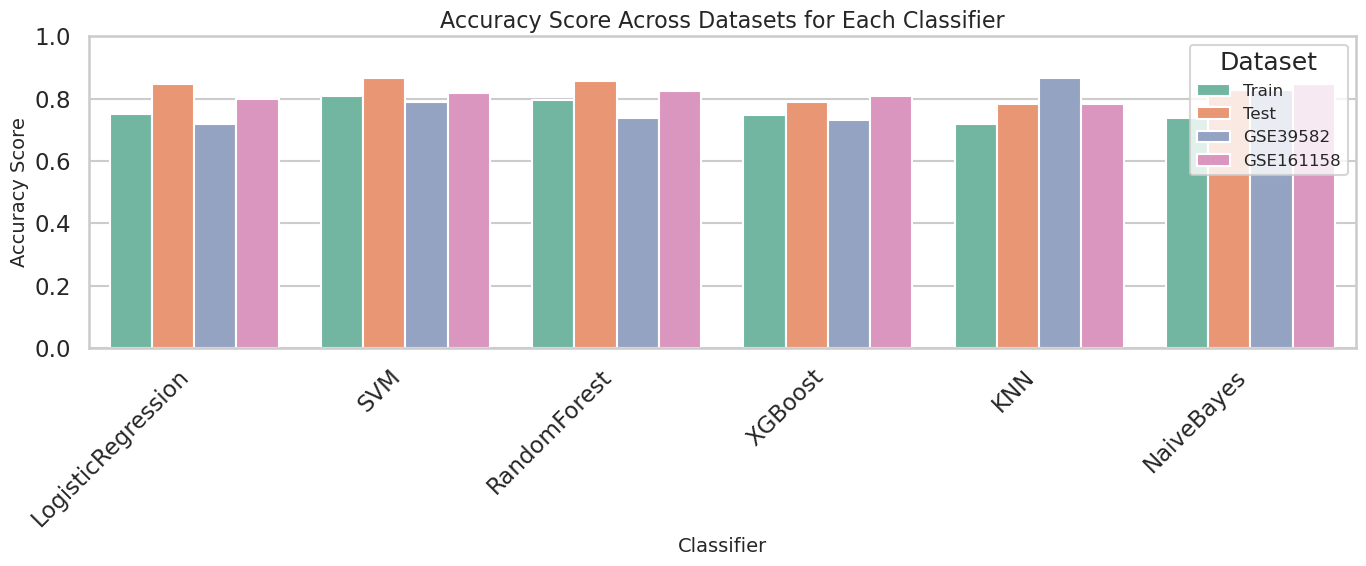

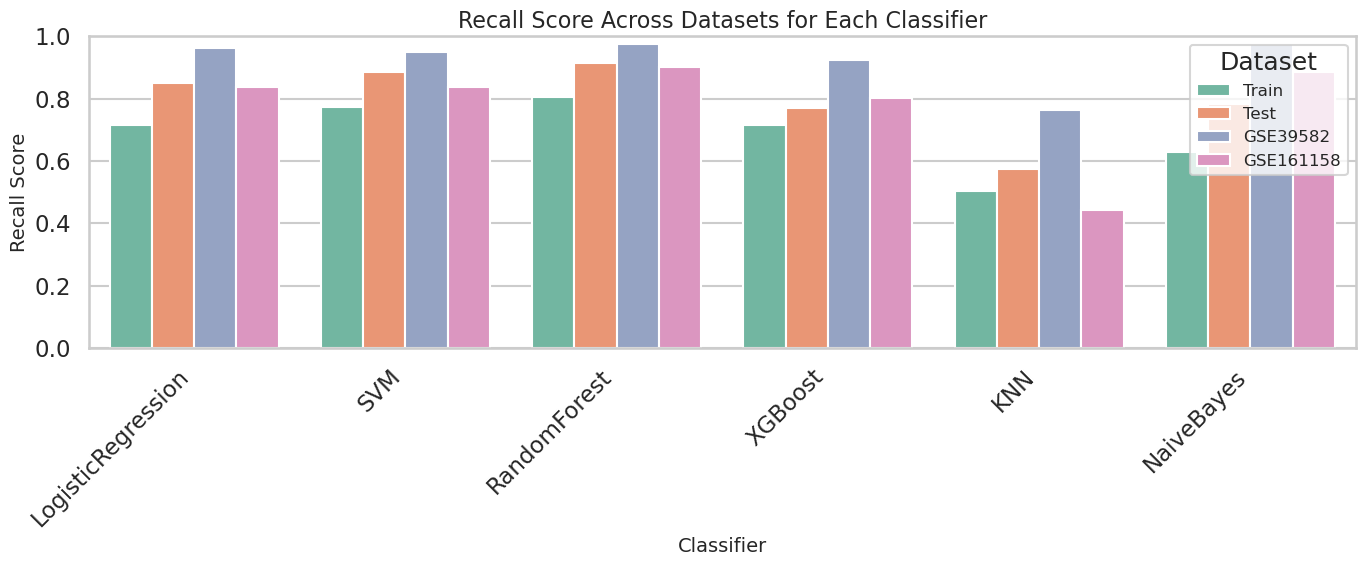

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid", context="talk")

# Plot F1 and MCC separately for clarity
for metric in ['Accuracy', 'Recall']:
    plt.figure(figsize=(14, 6))
    sns.barplot(
        data=plot_df[plot_df['Metric'] == metric],
        x="Model", y="Score", hue="Dataset",
        palette="Set2"
    )
    plt.title(f"{metric} Score Across Datasets for Each Classifier", fontsize=16)
    plt.ylabel(f"{metric} Score", fontsize=14)
    plt.xlabel("Classifier", fontsize=14)
    plt.ylim(0, 1)
    plt.legend(title="Dataset", loc='best', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

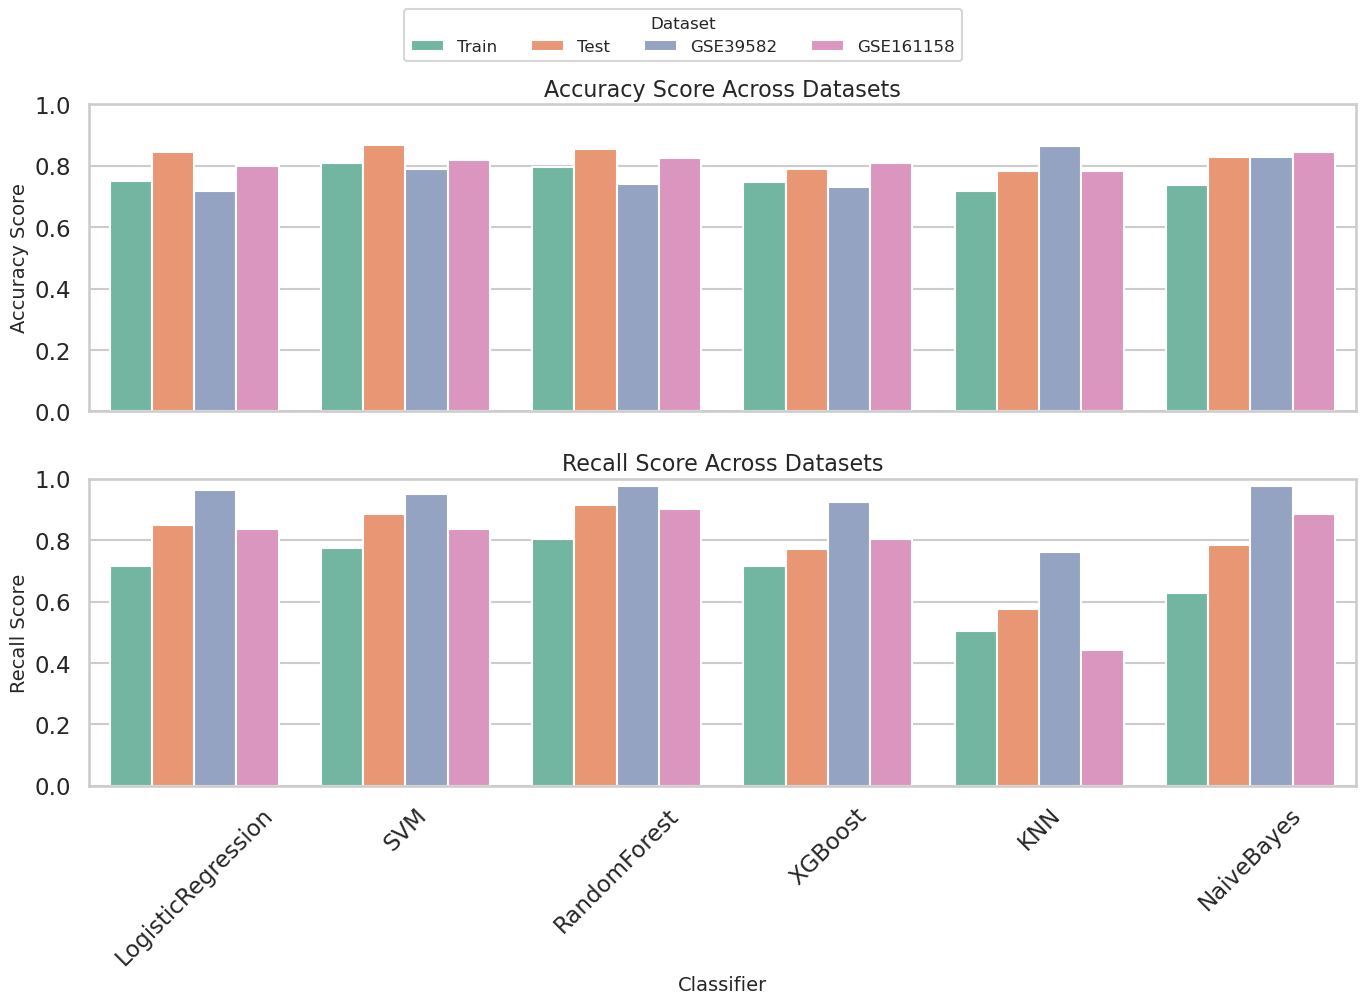

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid", context="talk")

# Create subplots: 1 column, 2 rows
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, sharey=True)

# Metrics to plot
metrics = ['Accuracy', 'Recall']
colors = sns.color_palette("Set2")

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(
        data=plot_df[plot_df['Metric'] == metric],
        x="Model", y="Score", hue="Dataset",
        palette=colors,
        ax=ax
    )
    ax.set_title(f"{metric} Score Across Datasets", fontsize=16)
    ax.set_ylabel(f"{metric} Score", fontsize=14)
    ax.set_xlabel("")  # We'll set xlabel only once below
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)

# Remove individual legends
for ax in axes:
    ax.legend_.remove()

# Add shared legend outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Dataset", loc='upper center', bbox_to_anchor=(0.5, 1.02),
           ncol=len(labels), fontsize=12, title_fontsize=12)

# Set shared x-label
axes[-1].set_xlabel("Classifier", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for legend
plt.show()

fig.savefig("classifier_accuracy_recall.png", dpi=600, bbox_inches='tight')

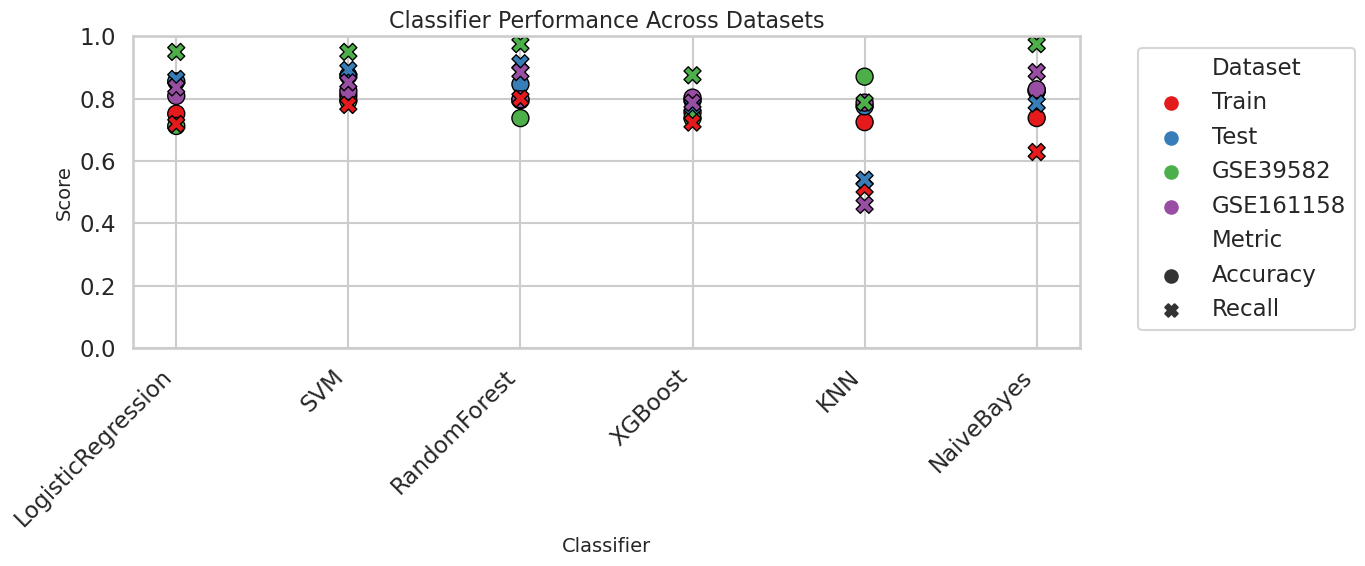

In [58]:
plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=plot_df,
    x="Model", y="Score",
    hue="Dataset", style="Metric",
    s=150, palette="Set1", edgecolor="black"
)
plt.title("Classifier Performance Across Datasets", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Classifier", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
performance_table = pd.DataFrame(performance_table)

performance_table.to_csv("model_performances.csv", index=False)
performance_table.head()

,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Train MCC,Train AUC,Test Accuracy,Test Precision,Test Recall,...,GSE39582 AUC,GSE161158 Accuracy,GSE161158 Precision,GSE161158 Recall,GSE161158 F1,GSE161158 MCC,GSE161158 AUC,CV10 AUC Mean,CV10 AUC Std,Best Params
0,LogisticRegression,0.750000,0.763128,0.715203,0.735857,0.502635,0.825393,0.846154,0.802721,0.848921,...,0.935268,0.797872,0.645570,0.836066,0.728571,0.583894,0.895572,0.825393,0.033513,"{'clf__penalty': 'l2', 'clf__C': 0.00464158883..."
1,SVM,0.807692,0.823771,0.773462,0.796907,0.616857,0.893574,0.867692,0.820000,0.884892,...,0.948083,0.819149,0.680000,0.836066,0.750000,0.618673,0.934943,0.893574,0.017671,"{'clf__kernel': 'rbf', 'clf__C': 1}"
2,RandomForest,0.794615,0.783952,0.804836,0.793010,0.591299,0.883603,0.855385,0.783951,0.913669,...,0.949238,0.824468,0.670732,0.901639,0.769231,0.650507,0.932361,0.883603,0.033009,"{'clf__n_estimators': 500, 'clf__min_samples_s..."
3,XGBoost,0.746981,0.764163,0.715378,0.738317,0.495749,0.834476,0.790769,0.748252,0.769784,...,0.896980,0.808511,0.671233,0.803279,0.731343,0.590118,0.889247,0.834476,0.025895,"{'clf__n_estimators': 100, 'clf__max_depth': 3..."
4,KNN,0.717692,0.865293,0.502951,0.633412,0.472967,0.838385,0.781538,0.869565,0.575540,...,0.916032,0.781915,0.794118,0.442623,0.568421,0.471351,0.831160,0.838385,0.029955,{'clf__n_neighbors': 9}


In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
roc_cv_train = {}
mean_fpr = np.linspace(0, 1, 100)

for name, model in best_models.items():
    print(f"CV ROC for {name}...")
    tprs = []
    aucs = []

    if name == "XGBoost":
        X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)
        X_data, y_data = X_train_res, y_train_res
    else:
        X_data, y_data = X_train, y_train

    for train_idx, val_idx in cv10.split(X_data, y_data):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        model.fit(X_tr, y_tr)
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    roc_cv_train[name] = (mean_fpr, mean_tpr, std_tpr, mean_auc, std_auc)

def plot_mean_roc_curves_cv(
    roc_dict, title, filename, figsize=(6.5, 6), fontsize=13
):
    plt.figure(figsize=figsize)
    for model_name, (fpr, mean_tpr, _, mean_auc, _) in roc_dict.items():
        plt.plot(fpr, mean_tpr, lw=2,
                 label=f"{model_name} (AUC = {mean_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.title(title, fontsize=fontsize + 2)
    plt.legend(loc="lower right", fontsize=fontsize - 1)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(filename, dpi=600)
    plt.close()


def compute_standard_roc(models_dict, X, y):
    roc_dict = {}
    for name, model in models_dict.items():
        y_proba = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_proba)
        auc_score = auc(fpr, tpr)
        roc_dict[name] = (fpr, tpr, auc_score)
    return roc_dict

def plot_standard_roc(roc_dict, title, filename, figsize=(6.5, 6), fontsize=13):
    plt.figure(figsize=figsize)
    for model_name, (fpr, tpr, auc_score) in roc_dict.items():
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.title(title, fontsize=fontsize + 2)
    plt.legend(loc="lower right", fontsize=fontsize - 1)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(filename, dpi=600)
    plt.close()


# Cross-validated (Train)
plot_mean_roc_curves_cv(
    roc_cv_train,
    "Cross-Validated ROC Curve (Train Set)",
    "roc_train_cv.png"
)

# Standard Test Set
roc_test = compute_standard_roc(best_models, X_test, y_test)
plot_standard_roc(roc_test, "ROC Curve - Test Set", "roc_test.png")

# Validation Set 1 (GSE39582)
roc_val1 = compute_standard_roc(best_models, X_val1, y_val1)
plot_standard_roc(roc_val1, "ROC Curve - GSE39582", "roc_gse39582.png")

# Validation Set 2 (GSE161158)
roc_val2 = compute_standard_roc(best_models, X_val2, y_val2)
plot_standard_roc(roc_val2, "ROC Curve - GSE161158", "roc_gse161158.png")


CV ROC for LogisticRegression...
CV ROC for SVM...
CV ROC for RandomForest...
CV ROC for XGBoost...
CV ROC for KNN...
CV ROC for NaiveBayes...


# Create a summary DataFrame
summary_auc = pd.DataFrame(columns=["Train", "Test", "GSE39582", "GSE161158"])

# Populate the DataFrame
for model_name in best_models.keys():
    train_auc = auc(*roc_train[model_name])
    test_auc = auc(*roc_test[model_name])
    val1_auc = auc(*roc_val1[model_name])
    val2_auc = auc(*roc_val2[model_name])

    summary_auc.loc[model_name] = [train_auc, test_auc, val1_auc, val2_auc]

# Round for clarity
summary_auc = summary_auc.round(3)

# Save to CSV (or Excel)
summary_auc.to_csv("classifier_auc_summary.csv")
# Alternatively:
# summary_auc.to_excel("classifier_auc_summary.xlsx")

# Optional: display the table
print(summary_auc)

In [24]:
# Create summary DataFrame for AUC scores
summary_auc = pd.DataFrame(columns=["Train", "Test", "GSE39582", "GSE161158"])

for model_name in best_models.keys():
    # Get CV-based training AUC (mean from cross_validate)
    train_auc = train_roc_data[model_name]
    
    # Get test AUC (directly computed)
    test_auc = results[model_name]["Test AUC"]
    
    # Get validation AUCs
    gse39582_auc = val_results.get((model_name, "GSE39582"), None)
    gse161158_auc = val_results.get((model_name, "GSE161158"), None)
    
    summary_auc.loc[model_name] = [train_auc, test_auc, gse39582_auc, gse161158_auc]

# Round for clarity
summary_auc = summary_auc.round(3)

# Save to CSV
summary_auc.to_csv("classifier_auc_summary.csv")

# Display
print(summary_auc)


                    Train   Test  GSE39582  GSE161158
LogisticRegression  0.825  0.915     0.935      0.896
SVM                 0.894  0.949     0.948      0.935
RandomForest        0.884  0.942     0.949      0.932
XGBoost             0.834  0.883     0.897      0.889
KNN                 0.838  0.869     0.916      0.831
NaiveBayes          0.820  0.907     0.952      0.923


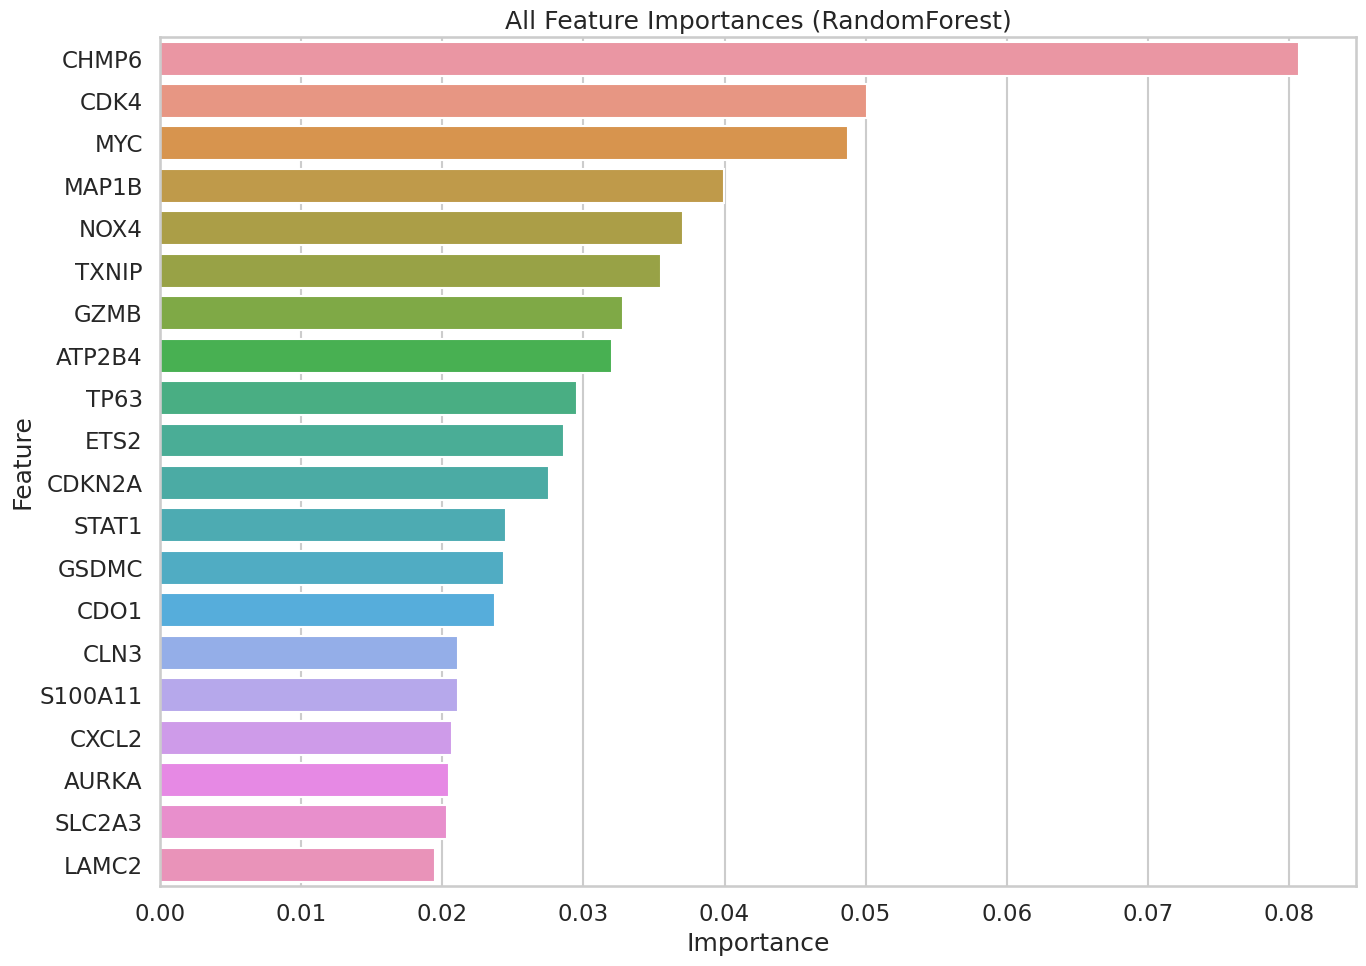

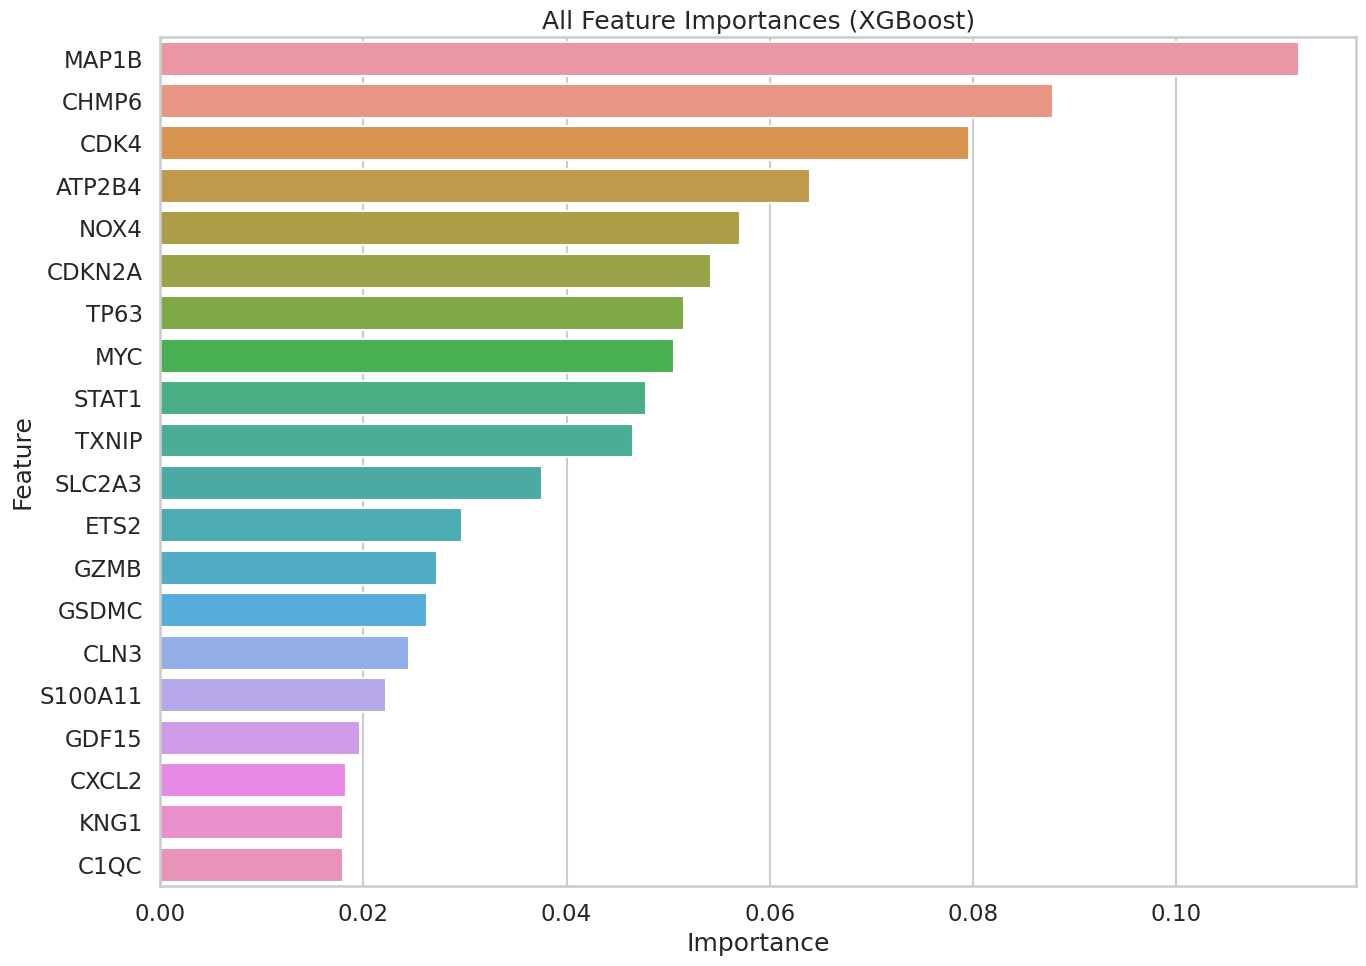

In [25]:
# Feature importance plots for RF and XGB
for name in ["RandomForest", "XGBoost"]:
    model = best_models[name].named_steps['clf']
    importances = model.feature_importances_
    feat_names = train.drop(columns=["RiskClass"]).columns
    importance_df = pd.DataFrame({"Feature": feat_names, "Importance": importances}).sort_values(by="Importance", ascending=False).head(20)
    plt.figure(figsize=(14, 10))
    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title(f"All Feature Importances ({name})")
    plt.tight_layout()
    plt.savefig(f"feature_importance_{name}.png", dpi=600)
    plt.show()